## BOX COX TRANSFORM


Some forecasting & decomposition methods perform better if the variance of the time series does not change with the Level of the time series (e.g., ARIMA).


The log transform does not always stabilize the variance of a time series. 
It depends on the time series.

The Box Cox transform is a more general transform that can be used to stabilize the variance of a time series


To stabilise the variance we want the transformation to remove the interaction between the
trend and any seasonality or noise term so we can write them additively: ` 𝑦 = 𝑇rend + 𝑆easonality + 𝑅esidual`



The Box-Cox transform is defined as:

$${\displaystyle y_{i}^{(\lambda )}={\begin{cases}{\dfrac {y_{i}^{\lambda }-1}{\lambda }}&{\text{if }}\lambda \neq 0,\\\ln y_{i}&{\text{if }}\lambda =0,\end{cases}}}$$





<br>
<img src='./BOXCOX.PNG' class='rotate_image' style='transform:rotate(270deg)'>
<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load the data

In [2]:
df = pd.read_csv('../../Datasets/example_air_passengers.csv', parse_dates=['ds'], index_col=['ds'])
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


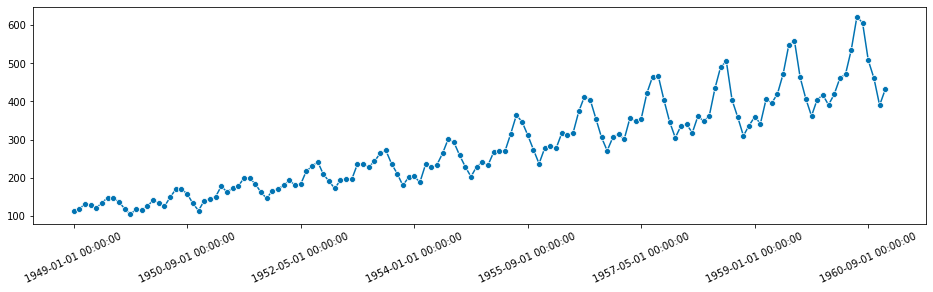

In [3]:
from sktime.utils.plotting import plot_series

plot_series(df);
plt.xticks(rotation=25);


`from scipy.stats import boxcox`

Return a dataset transformed by a Box-Cox power transformation.

`
lmbda : {None, scalar}, optional
    If lmbda is not None, do the transformation for that value. 
    If lmbda is None, find the lambda that maximizes the log-likelihood function and return it as the second output argument.
`

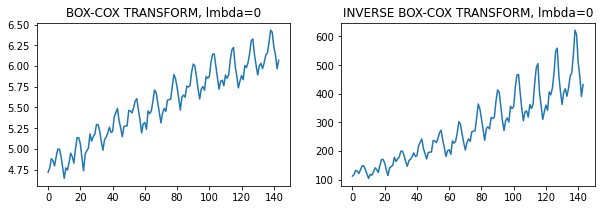

In [9]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# y = (x**lmbda - 1) / lmbda  if lmbda != 0
#   = log(x)                  if lmbda == 0

y_hat = boxcox(df['y'], lmbda=0)

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(y_hat);
plt.title(f'BOX-COX TRANSFORM, lmbda=0');
plt.subplot(122)
plt.plot(inv_boxcox(y_hat, 0));
plt.title(f'INVERSE BOX-COX TRANSFORM, lmbda=0');



### We can use maximul likelihood estimation to find the lamda that stabilize the variance

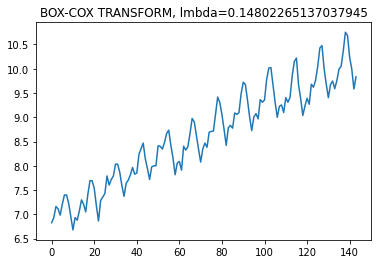

In [10]:
y_hat, lambda_ = boxcox(df['y'], lmbda=None)

plt.plot(y_hat);
plt.title(f'BOX-COX TRANSFORM, lmbda={lambda_}');

#### Box Cox transform for differnt values of lmbda

In [11]:
lmbdas = [
    -1,  # Inverse transform y^(-1)
    -0.5,  # inverse square root transform y^(-1/2)
    0,  # Log transform ln(y)
    0.5,  # Square root transform sqrt(y)
    1,  # y - 1
    2,  # Square transform y^2
]

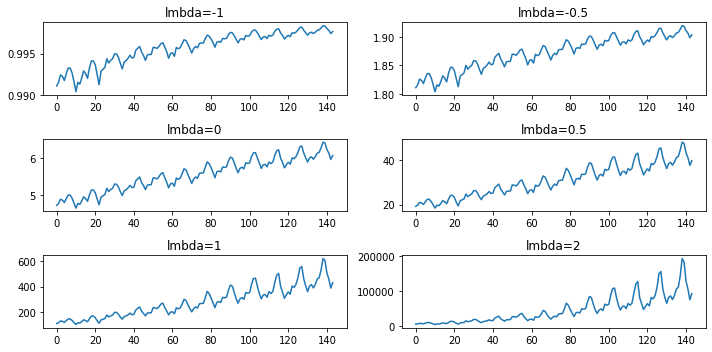

In [12]:
fig,ax = plt.subplots(ncols=2, nrows=3 , figsize=(10,5))
ax = ax.flatten()
for i,l in enumerate(lmbdas):

    y_hat = boxcox(df['y'], lmbda=l)
    ax[i].plot(y_hat)
    ax[i].set(title=f'lmbda={l}')
    
plt.tight_layout()

## Box-Cox with sktime 

We show how to use the Box-Cox transformer from sktime which allows us
to use the Guerrero method to select $\lambda$. The Guerrero method does not make 
assumptions about the underlying distribution and tries to specifically stabilise 
the variance across the time series.

In [15]:
from sktime.transformations.series.boxcox import BoxCoxTransformer


# sp=12 # sp should be set to the seasonal period
box_cox = BoxCoxTransformer(method='guerrero', sp=12)

In [16]:
y_hat = box_cox.fit_transform(df['y'])

#### method='guerrero'


<style>
.image{
    height:1500px
}
</style>

<br>
<img src='./guerroro (1).jpg' class='image'>
<br>


<br>
<img src='./guerroro (2).jpg' class='image'>
<br>

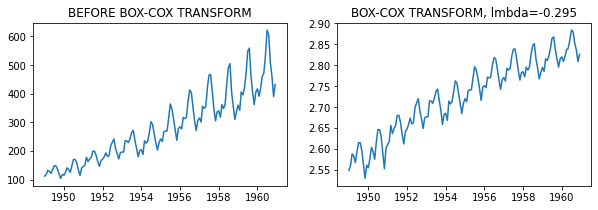

In [23]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(df['y'])
plt.title(f'BEFORE BOX-COX TRANSFORM');
plt.subplot(122)
plt.plot(y_hat);
plt.title(f'BOX-COX TRANSFORM, lmbda={box_cox.lambda_:0.3f}');

#### method='MLE'

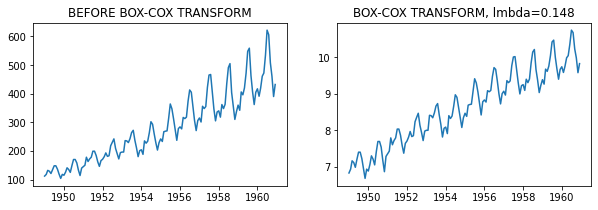

In [24]:
box_cox = BoxCoxTransformer(method='mle', sp=12)
y_hat = box_cox.fit_transform(df['y'])

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(df['y'])
plt.title(f'BEFORE BOX-COX TRANSFORM');
plt.subplot(122)
plt.plot(y_hat);
plt.title(f'BOX-COX TRANSFORM, lmbda={box_cox.lambda_:0.3f}');

## Log and Box Cox with Feature-engine

We might want to apply the Box Cox transform to multiple variables and as part 
of a pipeline. This can be easily done by using the Box Cox transformer from 
Feature-engine. Scipy is used under the hood and so the MLE method is used to pick $\lambda$.

In [25]:
data = df.copy()
# Add a new column to show Box Cox transformer handling two columns
data["x"] = df["y"] * 2

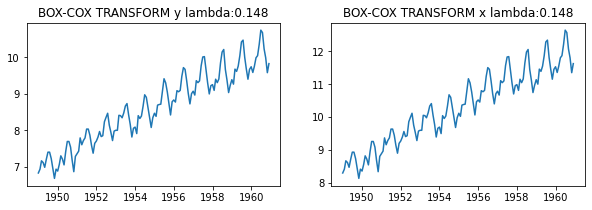

In [37]:
from feature_engine.transformation import BoxCoxTransformer, LogTransformer


box_cox = BoxCoxTransformer(variables=['x', 'y'])
y_hat = box_cox.fit_transform(data)

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(y_hat['y'])
plt.title(f'BOX-COX TRANSFORM y lambda:{box_cox.lambda_dict_["y"]:.3f}');
plt.subplot(122)
plt.plot(y_hat['x']);
plt.title(f'BOX-COX TRANSFORM x lambda:{box_cox.lambda_dict_["x"]:.3f}');

We can access the value of lambda that was automatically selected using the `lambda_dict_`
attribute.

In [33]:
box_cox.lambda_dict_

{'x': 0.14802255370969325, 'y': 0.14802265137037945}

## The LogTransformer

`The LogTransformer()` applies the natural logarithm or the base 10 logarithm to numerical variables. The natural logarithm is the logarithm in base e.

`The LogTransformer()` only works with positive values. If the variable contains a zero or a negative value the transformer will return an error.

A list of variables can be passed as an argument


<br>
<img src='./LOG-TRANSFORM.PNG'>
<br>

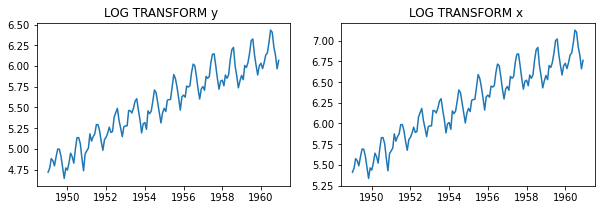

In [38]:
log_transformer = LogTransformer(variables=['x', 'y'])
y_hat = log_transformer.fit_transform(data)

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(y_hat['y'])
plt.title(f'LOG TRANSFORM y ');
plt.subplot(122)
plt.plot(y_hat['x']);
plt.title(f'LOG TRANSFORM x ');